In [1]:
import re
import os
import mlflow
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Ignore warnings:
warnings.filterwarnings('ignore')

# Reading the dataset:
trainDF = pd.read_csv("../data/raw/titanic/train.csv")
testDF = pd.read_csv("../data/raw/titanic/test.csv")

def get_features(data):
    # Divide the data:
    target = "Survived"
    features = [col for col in data if col not in ['PassengerId','Survived', 'Name', 'Ticket', 'Cabin']] # Main features

    X = data[features].copy()
    y = data[target].copy()

    # Feature enginering:
    pattern = re.compile(r",\s([A-Za-z]+)\.?") # Patter to get the title of the passengers
    ticket_counts = data['Ticket'].value_counts() # Count the tickets to generate another feature

    # Adding the new features to the DF:
    X['Titles'] = data['Name'].str.extract(pattern, expand=False)
    X['TicketGroupSize'] = data['Ticket'].map(ticket_counts) # Map the ticket to the total count
    X['HasCabin'] = data['Cabin'].notnull().astype(int) # NaN means no cabin assigned = No first class passenger

    # Get numeric and categorical features:
    num_feat = [col for col in X if col not in ['Sex', 'Embarked', 'Titles', 'TicketGroupSize', 'HasCabin']]
    cat_feat = ['Sex', 'Embarked', 'Titles', 'TicketGroupSize', 'HasCabin']

    return X, y, num_feat, cat_feat

X_train, y_train, num_feat, cat_feat  = get_features(trainDF)

X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Titles,TicketGroupSize,HasCabin
0,3,male,22.0,1,0,7.2500,S,Mr,1,0
1,1,female,38.0,1,0,71.2833,C,Mrs,1,1
2,3,female,26.0,0,0,7.9250,S,Miss,1,0
3,1,female,35.0,1,0,53.1000,S,Mrs,2,1
4,3,male,35.0,0,0,8.0500,S,Mr,1,0


In [3]:
# Define the pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoding', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_feat),
    ('cat', categorical_transformer, cat_feat)
])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=1000, random_state=42))
])

In [4]:
y_pred_cv = cross_val_predict(estimator=pipeline, X=X_train, y=y_train, cv=5)

report = classification_report(y_train, y_pred_cv, target_names=['No survive: 0', 'Survive: 1'])
print(report)

               precision    recall  f1-score   support

No survive: 0       0.86      0.86      0.86       549
   Survive: 1       0.78      0.77      0.77       342

     accuracy                           0.82       891
    macro avg       0.82      0.81      0.81       891
 weighted avg       0.82      0.82      0.82       891



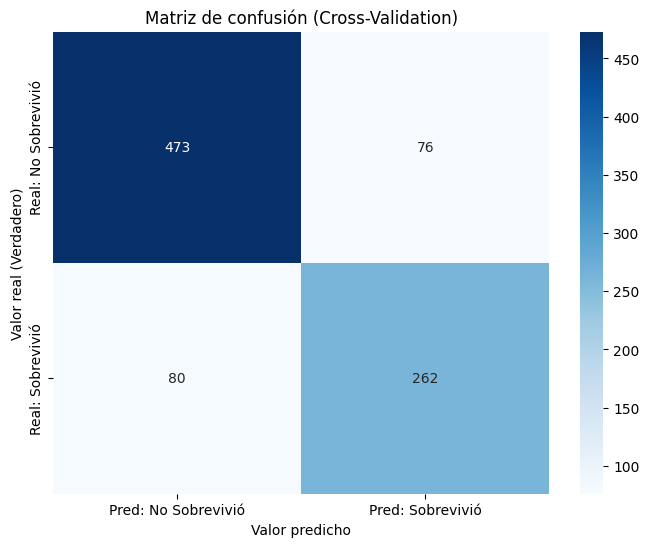

2025/11/01 19:39:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Training the model with the whole data...


2025/11/01 19:39:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Expetiment finished: All data saved to MLFlow


In [ ]:
# MLFlow information:
MLFLOW_TRACKING = True
EXPERIMENT_NAME = "Titanic Classification"
RUN_NAME = "Try: Logistic Regression with GridSearchCV"

if MLFLOW_TRACKING:
    mlflow.set_experiment(EXPERIMENT_NAME)

    with mlflow.start_run(run_name=RUN_NAME):

        # Record report txt as an artifact:
        with open("../reports/titanic_classification_report.txt", "w") as f:
            f.write(report)
        mlflow.log_artifact("../reports/titanic_classification_report.txt")

        cm = confusion_matrix(y_train, y_pred_cv) # Create confusion matrix
        fig_cm, ax_cm = plt.subplots(figsize=(8, 6)) # Confusion matrix dimensions

        sns.heatmap(
            cm,
            annot=True,      # Show numbers
            fmt='d',         # Number format
            cmap='Blues',    # Color
            ax = ax_cm,      # Draw in axes
            xticklabels=['Pred: No Sobrevivió', 'Pred: Sobrevivió'],
            yticklabels=['Real: No Sobrevivió', 'Real: Sobrevivió']
        )

        ax_cm.set_title('Matriz de confusión (Cross-Validation)')
        ax_cm.set_ylabel('Valor real (Verdadero)')
        ax_cm.set_xlabel('Valor predicho')

        cm_filename = "../reports/figures/titanic_confusion_matrix_cv.png"
        fig_cm.savefig(cm_filename)
        plt.show()
        plt.close(fig_cm)
        mlflow.log_artifact(cm_filename)
        os.remove(cm_filename)

        # Record the metrics individually
        report_dict = classification_report(y_train, y_pred_cv, output_dict=True)
        metrics_to_log = {
            'accuracy': report_dict['accuracy'],
            'weighted_avg_precision': report_dict['weighted avg']['precision'],
            'weighted_avg_recall': report_dict['weighted avg']['recall'],
            'weighted_avg_f1-score': report_dict['weighted avg']['f1-score'],
            'class_1_f1-score': report_dict['1']['f1-score']
        }
        mlflow.log_metrics(metrics_to_log)

        # Record the model:
        print("Training the model with the whole data...")
        pipeline.fit(X_train, y_train)
        mlflow.sklearn.log_model(pipeline, "logistic_regression_baseline")

        print("Expetiment finished: All data saved to MLFlow")